In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import pickle
import lightgbm
import os
from lime import lime_tabular
import sys
sys.path.append('..')
from lirme_v2 import LIRME
from sklearn.utils import shuffle
from scipy.stats import spearmanr, kendalltau
import sys
sys.path.append('..')
from get_exp_new import lime_exp, shap_exp, random_exp, grad_exp
from sklearn.metrics import ndcg_score, jaccard_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation_pointwise import get_fidelity_ltr,validity_completeness,  get_explain_ndcg, validity_completeness, get_infidelity, get_fidelity_ltr, get_dpff, summarize
from tabulate import tabulate

In [121]:
color_list = {
    'lpi': 'blue',
    'lirme': 'gold',
    'lime': 'darkorange',
    'shap': 'brown',
    'exs_top_k_rank': 'cyan', 
    'exs_top_k_binary': 'lightgreen', 
    'exs_score': 'magenta',
    'random_d': 'black'
}

In [109]:
dataset_name = 'mq2008'

In [110]:
def load_and_summarize(file_name):
    eval_ = pickle.load( open( file_name, "rb" ) )
    summary_ = summarize(eval_)
    
    summary_df_ = pd.DataFrame(summary_)
    summary_df_ = summary_df_.drop(['explain_ndcg'], axis=1)
    summary_df_ = summary_df_.reindex(columns=['dpff', 'fidelity_ltr', 'completeness', 'validity', 'infidelity'])
    summary_df_ = summary_df_.reindex(index=['lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank',
           'lime', 'shap', 'lpi',  'random_d'])
    summary_df_.columns = ['FF', 'Fidelity',  'Completeness', 'Validity', 'Infidelity']
    summary_df_.index = ['LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)','LIME', 'Shap', 'LPI',  'Random']
    
    return summary_df_

In [111]:
summary_df = load_and_summarize(f"./evals/{dataset_name}_evaluate_summary_v4_pointwise.p")#.round(2)

In [112]:
def process_ax(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 15, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 15, weight = 'bold', color = '0.2')

    return ax

In [115]:
def compact_summary(ev):
    new_ev = np.zeros((len(ev), len(ev[0][0])))
    for i in range(len(ev)): 
        new_ev[i, :] = np.mean(ev[i], axis=0)
    return new_ev

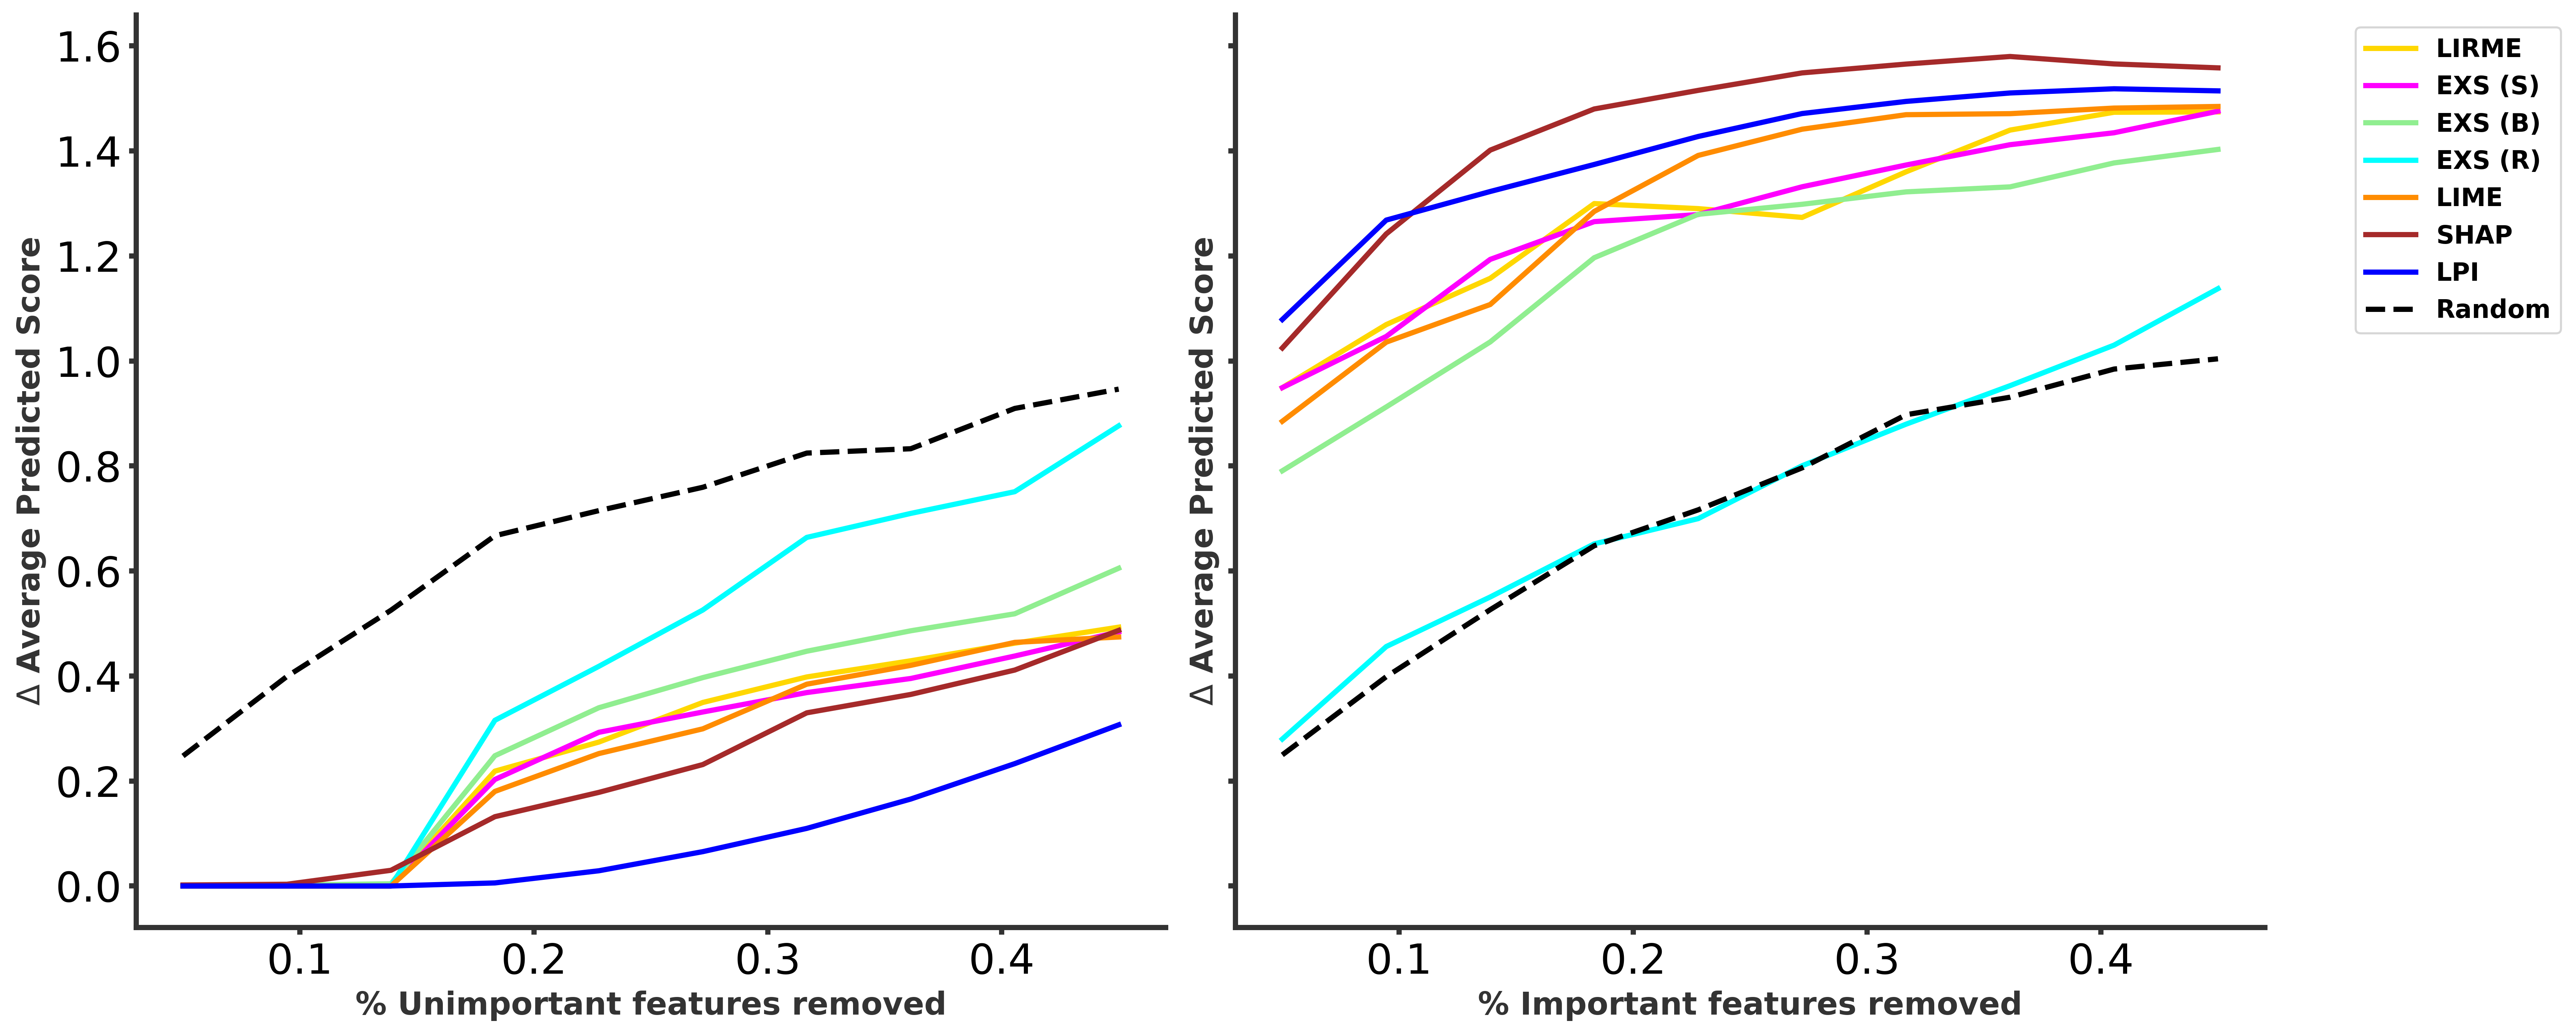

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7), sharey=True, dpi=400)
cutoff = np.linspace(0.05, 0.45, 10)

subset_exps = ['lirme',
           'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap', 'lpi', 'random_d']
subset_exps_alt = np.array(['LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)','LIME', 'SHAP', 'LPI', 'Random'])

eval_ = pickle.load( open( f"./evals/{dataset_name}_evaluate_summary_v4_pointwise.p", "rb" ) ) 

for i in range(len(subset_exps)):
    e = subset_exps[i]
    
    #per = avg_per_cutoff(cutoff, robust['synthetic']['preservation'], e)
    #per = np.array(eval_['validity'][e]).mean(axis=0)
    per = np.array(compact_summary(eval_['validity'][e])).mean(axis=0)
    
    if i == len(subset_exps) - 1:
        ax[0].plot(cutoff, per, label=subset_exps_alt[i], color=color_list[e], 
                   linewidth=2.5, linestyle='dashed')
    else:
        ax[0].plot(cutoff, per, label=subset_exps_alt[i], color=color_list[e], 
                   linewidth=2.5)
    ax[0].set_xlabel('% Unimportant features removed', fontsize=20)
    ax[0].set_ylabel('$\Delta$ Average Predicted Score')
    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[0] = process_ax(ax[0])
    
    #dele = avg_per_cutoff(cutoff, robust['synthetic']['deletion'], e)
    dele = np.array(compact_summary(eval_['completeness'][e])).mean(axis=0)
    
    if i == len(subset_exps) - 1:
        ax[1].plot(cutoff, dele, label=subset_exps_alt[i], color=color_list[e], 
                   linewidth=2.5, linestyle='dashed')
    else:
        ax[1].plot(cutoff, dele, label=subset_exps_alt[i], color=color_list[e], linewidth=2.5)
    
    ax[1].tick_params(axis='both', which='major', labelsize=20)
    ax[1].set_xlabel('% Important features removed', fontsize=20)
    ax[1].set_ylabel('$\Delta$ Average Predicted Score')
    ax[1] = process_ax(ax[1])

ax[1].legend(loc='upper right', prop = {'weight':'bold', 'size':12}, bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.savefig('./img/query_robustness_{}_v1.pdf'.format(dataset_name), bbox_inches='tight')

plt.show()

In [142]:
dataset_name = 'yahoo'
exps = pickle.load( open( "./exps/{}_pointwise_exps_v3.p".format(dataset_name), "rb"))
lpi_exps = pickle.load( open( "./exps/{}_pointwise_exps_v4.p".format(dataset_name), "rb"))

test_sample = pickle.load( open( "./data/{}_test_sample_v2.p".format(dataset_name), "rb" ) )
background_dict = pickle.load( open( "./data/{}_background_v3.p".format(dataset_name), "rb" ) )

for q in exps.keys():
    exps[q]['lpi'] = np.array(lpi_exps[q]['lpi'])

queries = list(exps.keys())
exp_names = list(exps[queries[0]].keys())
ranker = lightgbm.Booster(model_file='./models/lmart_{}_v2.txt'.format(dataset_name))

background = []
for q in background_dict:
    background.extend(background_dict[q])
    
background = np.array(background).reshape(-1, test_sample[list(test_sample.keys())[0]].shape[1])

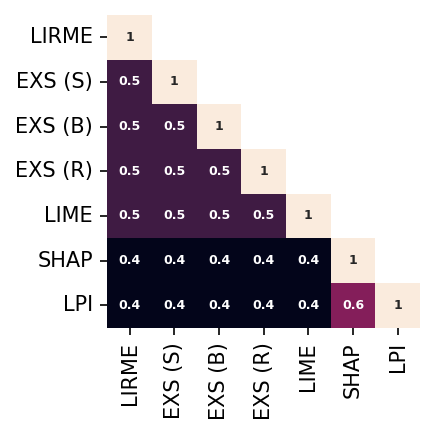

In [143]:
similarity = np.zeros((len(subset_exps) - 1, len(subset_exps) - 1))
#top_ks = threshold_vals[z]
top_ks = 0.5
top_k = int(top_ks * background.shape[1])
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

for i in range(0, similarity.shape[1]):
    e_i = subset_exps[i]
    for j in range(i + 1):
        e_j = subset_exps[j]
        temp = []
        for k in range(len(queries)):
            
            for l in range(len(exps[queries[k]][e_i])):
                first_exp = exps[queries[k]][e_i][l].flatten()
                second_exp = exps[queries[k]][e_j][l].flatten()
    
                ranked_first = np.argsort(np.abs(first_exp))[-top_k:][::-1]
                ranked_second = np.argsort(np.abs(second_exp))[-top_k:][::-1]
    
                f_exp_1 = np.zeros(background.shape[1])
                f_exp_1[ranked_first] = 1
    
                f_exp_2 = np.zeros(background.shape[1])
                f_exp_2[ranked_second] = 1
    
                temp.append(jaccard_score(np.abs(f_exp_1), np.abs(f_exp_2), average='binary'))
            #temp.append(kendalltau(np.abs(first_exp), np.abs(second_exp)).statistic)
        similarity[i][j] = np.nanmean(temp)

similarity[np.triu_indices(similarity.shape[0], +1)] = np.nan
sns.heatmap(similarity.round(1), xticklabels=subset_exps_alt[:-1], yticklabels=subset_exps_alt[:-1], 
    annot=True, annot_kws={"fontsize":6, 'fontweight':'bold'}, ax=ax, cbar=False)
plt.tight_layout()
plt.savefig('./img/pairwise_agrement_{}.pdf'.format(dataset_name))